# Language Detection from n-grams

### This is the second part to a series of blog posts on n-gram's. 
### Read part 1 here: http://blog.metasyn.pw/ngram-distributions/

So in part 1, we looked at the UDHR corpus to do some basic n-gram exploration. However, based on how ridiculously small that dataset it is, it won't be as useful for training a classifier. In this post, we're looking at the book data that can be downloaded from [here](http://opus.lingfil.uu.se/Books.php). 

Thanks and credit are due to [Andras Farkas](http://www.farkastranslations.com/) for the data and transaction, as well as following corpus compilation citation:
> Jörg Tiedemann, 2012, Parallel Data, Tools and Interfaces in OPUS. In Proceedings of the 8th International Conference on Language Resources and Evaluation (LREC 2012)

In the following code, we will do some basic visualizations, then try fitting some classifiers. Specifically, we'll look at multinomial naïve Bayes classification, and logistic regression. Once we have extracted the appopriate n-gram vectors, that is, counts of letters or combinations of letters from the books, we can use those as the features in our models. We'll do some simple test-train splits to test our models against unseen data.


In [92]:
# used to interact with the operating system
import os

# numpy is for numerical operations
import numpy as np

# pandas is for PANel DAta
import pandas as pd

# seaborn is for visualization
import seaborn as sns

# cufflinks is for visualization
# it comes from plotly
import cufflinks as cf

# this makes matplotlib show inline
%matplotlib inline

# used in the ETL process
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer as CV

# used in the classification process
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# used to compare classifiers
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

# used in the visualization process
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE



# ETL



In [2]:
BOOK_CORPUS = "/Users/aljohnson/data/books/"

In [11]:
FILE_NAMES = [f for f in os.listdir(BOOK_CORPUS)]

In [12]:
def file_reader(f):
    with open(BOOK_CORPUS + f, 'r', encoding='UTF8', errors='ignore') as infile:
        blob = infile.readlines()
        return blob

In [13]:
data = []
for f in FILE_NAMES:
    lines = file_reader(f)
    for line in lines:
        data.append([f, line.strip()])

In [14]:
# Add columns
df = pd.DataFrame(data, columns=['language', 'text'])

In [15]:
df.head()

,language,text
0,catalan,Source: Project GutenbergTranslation: Josep Ca...
1,catalan,Les Aventures De Tom Sawyer
2,catalan,Mark Twain
3,catalan,PREFACI.
4,catalan,La major part de les aventures consignades en ...


In [16]:
df.tail()

,language,text
909887,swedish,"Det glimmade svagt i vätan, de skumma gatlykto..."
909888,swedish,Ett fåtal genomblöta vägfarande skyndade förbi...
909889,swedish,"”Nåja”, sade Harris och sträckte ut sin hand e..."
909890,swedish,Skål för Tre män som har gått iland!”
909891,swedish,"Och Montmorency, som stod på bakbenen vid föns..."


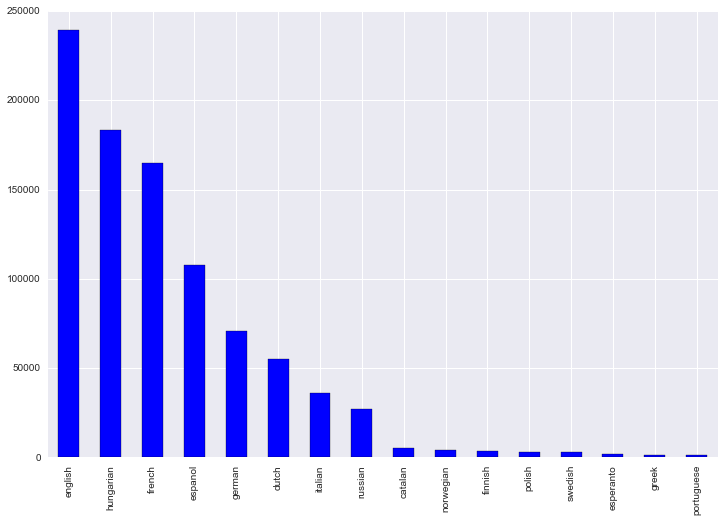

In [51]:
df.language.value_counts().plot(kind='bar', figsize=(12,8))

In [52]:
# so we have a highly disproportionate corpus by language size.
# that is ok though. we are aware of it.

In [53]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.language, test_size=0.33, random_state=33)

In [54]:
def rejoin(x, y):
    temp_df = pd.DataFrame.join(pd.DataFrame(y), pd.DataFrame(x))
    data = []
    for language in set(temp_df.language):
        data.append([language,' '.join(temp_df[temp_df.language == language].text)])
        
    return pd.DataFrame(data, columns=['language', 'text'])

In [55]:
# we will use these throughout the notebook
agglomed = rejoin(X_train, y_train)
testing_df = rejoin(X_test, y_test)

In [56]:
# sanity check
len(agglomed), len(testing_df)

(16, 16)

In [57]:
def vectorize_normalize(data, ngram_range=(1,1)):
    vectorizer = CV(analyzer='char', ngram_range=ngram_range)
    count_matrix = vectorizer.fit_transform(data)
    # divide by row totals for probability
    count_matrix /= count_matrix.sum(axis=1)
    df = pd.DataFrame(count_matrix, columns=vectorizer.get_feature_names())
    return df

In [58]:
# this took about a minute ~ 90 seconds on my macbook pro, FYI
ngram_probs_matrix = [vectorize_normalize(agglomed.text, ngram_range=(n,n)) for n in range(1,4)]
ngram_probs = [agglomed.join(p).drop('text', axis=1) for p in ngram_probs_matrix]

In [59]:
def plot_language_distribution(language, n=1, figsize=(20,15), ax=None):
    if language not in agglomed.language.values:
        return 'Not a valid language, dude.'
    # filter
    language_df = ngram_probs[n-1][ngram_probs[n].language == language]
    # drop columns that are zero
    language_df = language_df.loc[:, (language_df != 0).any(axis=0)]
    our_plot = language_df.plot(
        title=language, 
        kind='bar', 
        ax=ax, 
        figsize=figsize, 
        rot=45, 
        colormap='Accent')
    
    # change legend location
    our_plot.legend(loc=0, ncol=15, mode='expand')
    
    # remove x ticks
    our_plot.get_xaxis().set_visible(False)
    
    # set title
    our_plot.set_title(language, fontdict={'fontsize': '25'})
    
    return our_plot

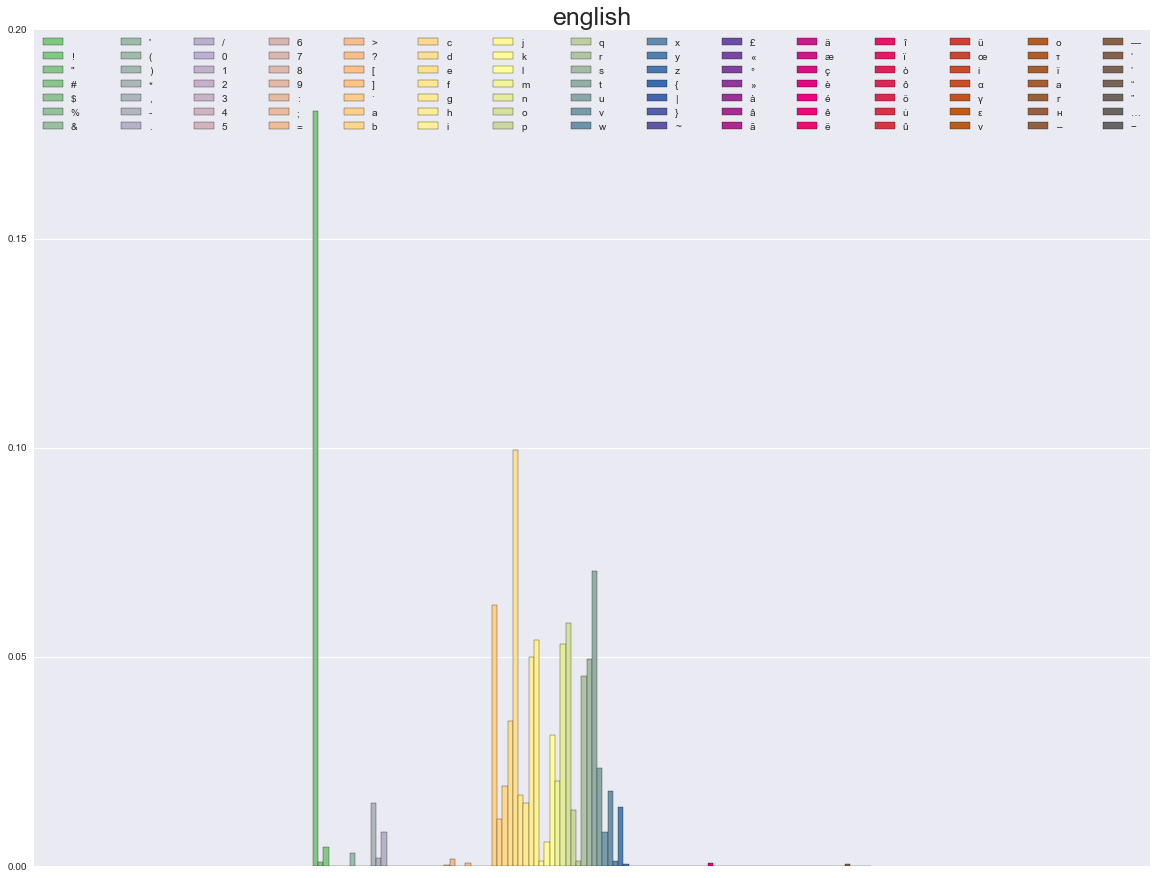

In [61]:
plot_language_distribution('english')

In [66]:
def plot_dists(languages):
    f, axarr = plt.subplots(len(languages))
    for n, l in enumerate(languages):
        plot_language_distribution(l, ax=axarr[n], figsize=(20, 100))

# beware !

The colors dont necessary refer to the same character. So you can't just refer color to color.

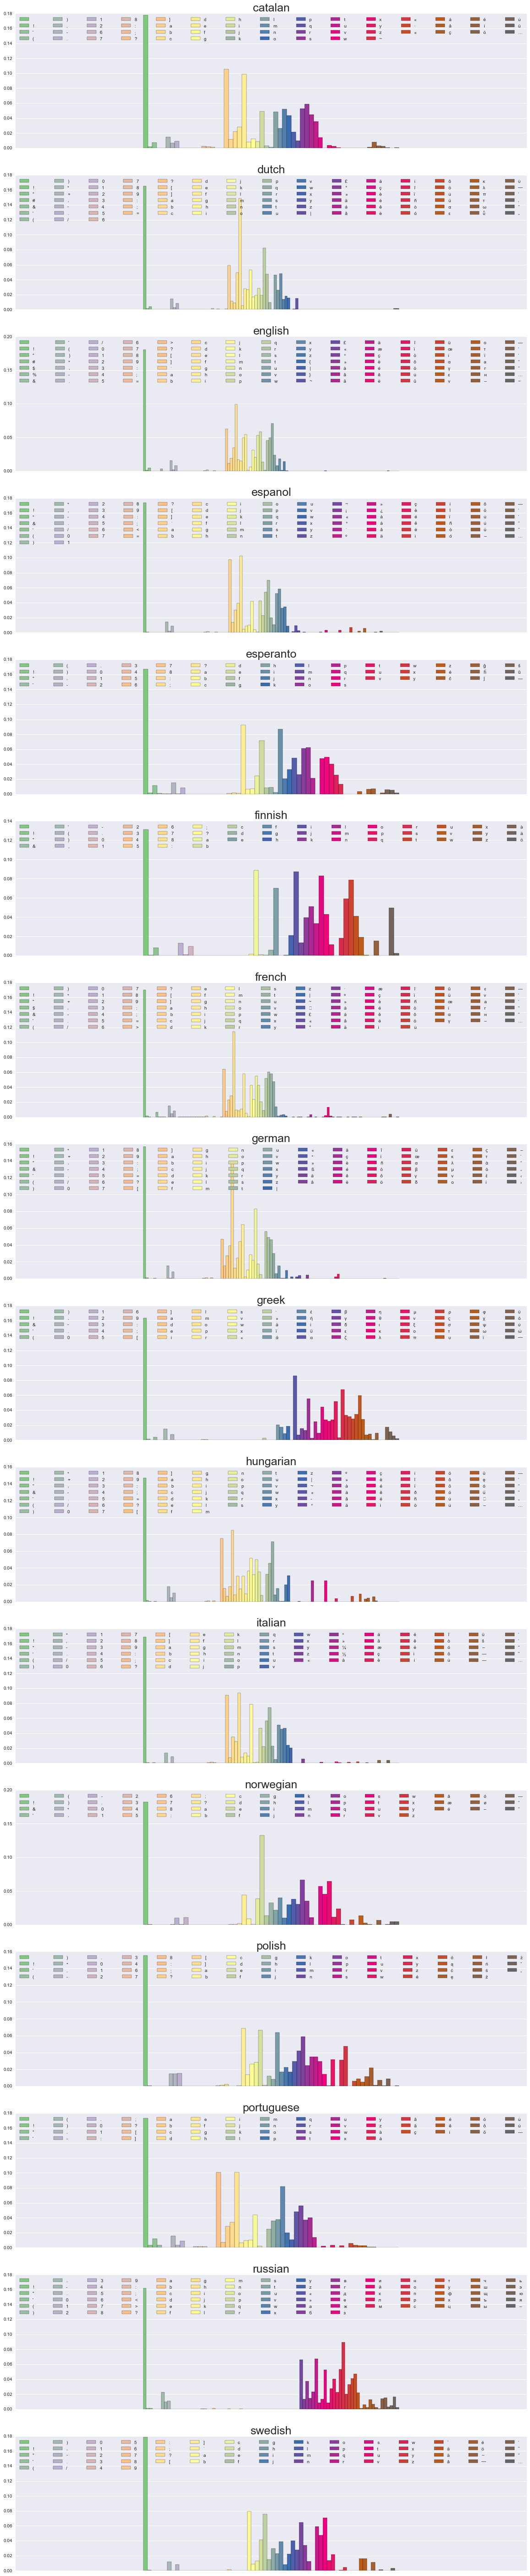

In [67]:
plot_dists(FILE_NAMES)

# feature selection

We need to do a little more cleaning 

In [68]:
# grab column names and shapes
# remove first feature because its a string, 'language'
ngram_cols = [pdist.drop('language', axis=1).columns for pdist in ngram_probs]
ngram_shapes = [pdist.drop('language', axis=1).shape for pdist in ngram_probs]

In [69]:
ngram_cols

[Index([' ', '!', '"', '#', '$', '%', '&', ''', '(', ')',
        ...
        '‘', '’', '‚', '“', '”', '„', '…', '‹', '›', '−'],
       dtype='object', length=215),
 Index([' !', ' "', ' #', ' $', ' &', ' '', ' (', ' )', ' *', ' +',
        ...
        '−q', '−r', '−s', '−t', '−u', '−v', '−w', '−y', '−~', '−−'],
       dtype='object', length=7121),
 Index([' ! ', ' !!', ' !"', ' !'', ' !(', ' !)', ' !.', ' !]', ' !_', ' !a',
        ...
        '−−p', '−−r', '−−s', '−−t', '−−u', '−−v', '−−w', '−−y', '−−~', '−−−'],
       dtype='object', length=76427)]

In [70]:
# get them empty features
empty_features = [pd.DataFrame(np.zeros(shape), columns=cols) 
                  for (shape, cols) in zip(ngram_shapes, ngram_cols)]

In [71]:
# sanity check
[(shape, f.head(1)) for (shape, f) in zip(ngram_shapes, empty_features)]

[((16, 215),       !  "  #  $  %  &  '  (  ) ...  ‘  ’  ‚  “  ”  „  …  ‹  ›  −
  0  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
  
  [1 rows x 215 columns]),
 ((16, 7121),
      !   "   #   $   &   '   (   )   *   + ...  −q  −r  −s  −t  −u  −v  −w  −y  \
  0   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   0   
  
     −~  −−  
  0   0   0  
  
  [1 rows x 7121 columns]),
 ((16, 76427),
      !    !!   !"   !'   !(   !)   !.   !]   !_   !a ...   −−p  −−r  −−s  −−t  \
  0    0    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   
  
     −−u  −−v  −−w  −−y  −−~  −−−  
  0    0    0    0    0    0    0  
  
  [1 rows x 76427 columns])]

# train our classifiers

In [72]:
# logistic regression initalization for each n-gram
logistic_clfs = [LogisticRegression(), LogisticRegression(), LogisticRegression()]

# multinomial naive bayes initlization for each n-gram
mnb_clfs = [MultinomialNB(), MultinomialNB(), MultinomialNB()]

classifier_groups = [logistic_clfs, mnb_clfs]

# this is for fitting really - the scoring doesnt mean much on a training set
for group in classifier_groups:
    print('*%'*35)
    print('Classifier: {}\n'.format(group[0]))
    
    for i, clf in enumerate(group):
        dist = ngram_probs_matrix[i]
        clf.fit(dist, agglomed.language)
        
        # get the training scores
        predictions = clf.predict(dist)
        score = precision_recall_fscore_support(agglomed.language, predictions, average='micro')
        
        print('='*70)
        print('n-graph distribution: {}'.format(i+1))
        print('feature size: {}'.format(dist.shape))
        print('Precision: {}'.format(score[0]))
        print('Recall: {}'.format(score[1]))
        print('F1 Score: {}\n'.format(score[2]))
        

*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%
Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

n-graph distribution: 1
feature size: (16, 215)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

n-graph distribution: 2
feature size: (16, 7121)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

n-graph distribution: 3
feature size: (16, 76427)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%
Classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

n-graph distribution: 1
feature size: (16, 215)
Precision: 0.6875
Recall: 0.6875
F1 Score: 0.6875

n-graph distribution: 2
feature size: (16, 7121)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

n-graph distribution: 3
feature size: (16, 76427)
Precision: 1.0
Recall: 

# wow !

JK THATS TRAINING DATA DUDE

In [73]:
# once again, this was like at least a minute. plus those fans. gotta love those fans.
t_ngram_probs_matrix = [vectorize_normalize(testing_df.text, ngram_range=(n,n)) for n in range(1,4)]
t_ngram_probs = [testing_df.join(p).drop('text', axis=1) for p in ngram_probs_matrix]

In [74]:
# the classifiers want the EXACT same features as input - so we're just filling in the missing features with zeros
# is there a better way to do this? hmm. idk.

empty_features[0].add(t_ngram_probs_matrix[0], fill_value=0).head(1)

,,!,"""",#,$,%,&,',(,),...,‘,’,‚,“,”,„,…,‹,›,−
0,0.163081,0.00146,0,0,0,0,0.000697,0.004263,0.000017,0.000017,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# add whatever features might be present in the testing data
# to the empty matrix of potential features from the training data
t_full = [empty_features[i].add(test_set, fill_value=0)
         for (i, test_set) in enumerate(t_ngram_probs_matrix)]

In [76]:
# however we might've actually added NEW features from the testing data
# so we need to reduce our features just to the training features
# we also don't need the 'language' column
t_reduced = [t[empty_features[i].columns]
         for (i, t) in enumerate(t_full)]

In [77]:
# are our dimensions the same?
[(t.shape, n) for (t, n) in zip(t_reduced, ngram_shapes)]

[((16, 215), (16, 215)), ((16, 7121), (16, 7121)), ((16, 76427), (16, 76427))]

In [78]:
# lets turn the above into a function
def vectorize_normalize_full(data, n=1):
        probs = vectorize_normalize(data, ngram_range=(n, n))
        prob_rows = probs.shape[0]
        truncated_empty_features = empty_features[n-1][:prob_rows]
        output = truncated_empty_features.add(probs, fill_value=0)
        return output[truncated_empty_features.columns]

In [83]:
test = vectorize_normalize_full(['hey hey hey'])
test2 = vectorize_normalize_full(['мы любим кексы'])

In [84]:
test

,,!,"""",#,$,%,&,',(,),...,‘,’,‚,“,”,„,…,‹,›,−
0,0.181818,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
test.loc[:, (test != 0).any(axis=0)]

,,e,h,y
0,0.181818,0.272727,0.272727,0.272727


In [86]:
test2.loc[:, (test2 != 0).any(axis=0)]

,,б,е,и,к,л,м,с,ы,ю
0,0.142857,0.071429,0.071429,0.071429,0.142857,0.071429,0.142857,0.071429,0.142857,0.071429


# testing our classifiers

the previous results were all just for the training data. here we are actually evaluating the classifiers on testing data.

In [87]:
# loop through our classifiers again
for group in classifier_groups:
    print('*%'*35)
    print('Classifier: {}\n'.format(group[0]))
    
    for i, clf in enumerate(group):
        dist = t_reduced[i]
        
        # get the testing scores
        # also had to drop the extra colum 'language' - its all zeros anwyay
        predictions = clf.predict(dist)
        score = precision_recall_fscore_support(testing_df.language, predictions, average='micro')
        
        # annotate
        print('='*70)
        print('n-graph distribution: {}'.format(i+1))
        print('feature size: {}'.format(dist.shape))
        print('Precision: {}'.format(score[0]))
        print('Recall: {}'.format(score[1]))
        print('F1 Score: {}\n'.format(score[2]))

*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%
Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

n-graph distribution: 1
feature size: (16, 215)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

n-graph distribution: 2
feature size: (16, 7121)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

n-graph distribution: 3
feature size: (16, 76427)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%*%
Classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

n-graph distribution: 1
feature size: (16, 215)
Precision: 0.6875
Recall: 0.6875
F1 Score: 0.6875

n-graph distribution: 2
feature size: (16, 7121)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

n-graph distribution: 3
feature size: (16, 76427)
Precision: 1.0
Recall: 

# manual testing

In [93]:
logistic_clfs[1].predict(vectorize_normalize_full(['hello, how are you, are you alive?'], n=2))

array(['english'], dtype=object)

In [94]:
logistic_clfs[1].predict(vectorize_normalize_full(['lol no dawg imma computer'], n=2))

array(['italian'], dtype=object)

In [41]:
# ^ our training data is constained to literary data sadly

In [95]:
mnb_clfs[1].predict(vectorize_normalize_full(['te amo mi amor, por que no quieres bilar conmigo ahora'], n=2))

array(['portuguese'], 
      dtype='<U10')

# Visualizing

In [96]:
# lets reduce our data into 3 dimensions

In [97]:
pca = PCA(n_components=3)
tsne = TSNE(n_components=3)
svd = TruncatedSVD(n_components=3)

def reduce(df, reducer):
    reduced_matrix = reducer.fit_transform(df)
    reduced_df = pd.DataFrame(reduced_matrix, columns=['PC1', 'PC2', 'PC3'])
    reduced_df.insert(0, 'language', agglomed.language)
    return reduced_df

In [98]:
unigrams_pca = reduce(ngram_probs_matrix[0], pca)

In [99]:
unigrams_pca.iplot(kind='scatter3d', x='PC1', y='PC2', z='PC3', mode='markers', text='language', colorscale='dark2', theme='space')

In [100]:
# here we get a quite distinct grouping of non-latin character scripts on one side

In [101]:
# lets try t-sne
unigrams_tsne = reduce(ngram_probs_matrix[0], tsne)
unigrams_tsne.iplot(kind='scatter3d', x='PC1', y='PC2', z='PC3', mode='markers', text='language', colorscale='dark2', theme='space')

In [102]:
# not quiet as coherent

In [103]:
# lets also try svd
unigrams_svd = reduce(ngram_probs_matrix[0], svd)
unigrams_svd.iplot(kind='scatter3d', x='PC1', y='PC2', z='PC3', mode='markers', text='language', colorscale='dark2', theme='space')

In [73]:
# much more similar to the pca, as expected